In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [4]:
Normaloperation = pd.read_csv("Normaloperation.csv",header=None)
Faultyoperation = pd.read_csv("Faultyoperation.csv",header=None)

In [7]:
Normaloperation.shape, Faultyoperation.shape

((18, 558), (18, 559))

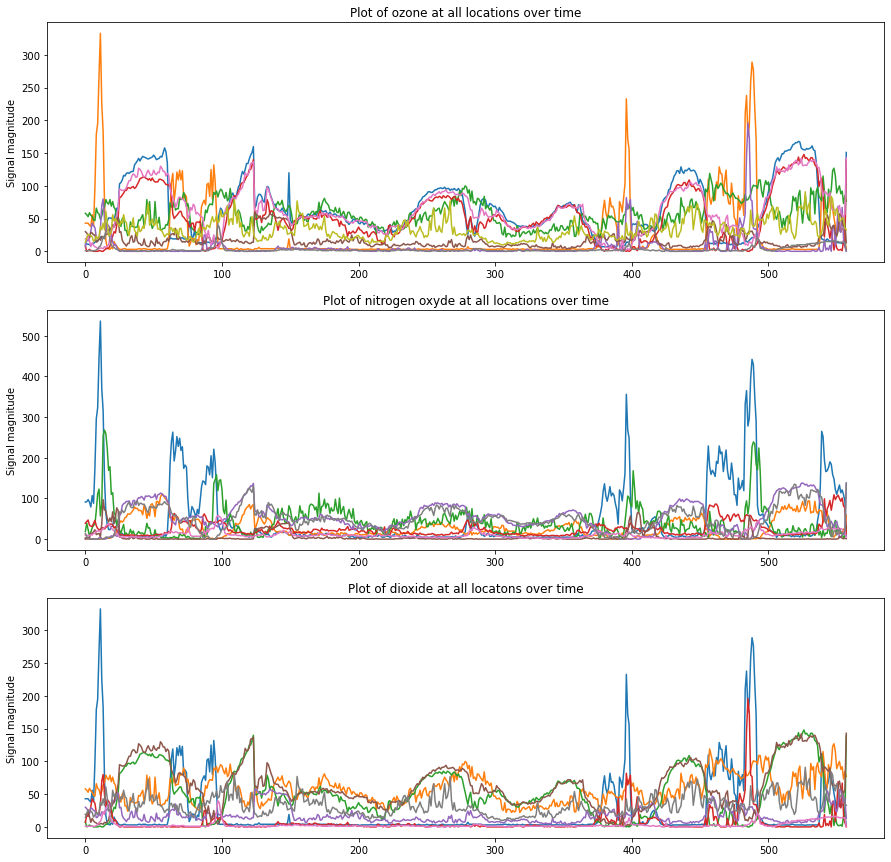

In [32]:
#plot sensor data
fig, axs = plt.subplots(3,1,figsize=(15,15))
axs[0].plot(Normaloperation.iloc[np.arange(0,17,2),:].T)
axs[0].set_title("Plot of ozone at all locations over time")
axs[0].set_ylabel('Signal magnitude')

axs[1].plot(Normaloperation.iloc[np.arange(1,17,2),:].T)
axs[1].set_title("Plot of nitrogen oxyde at all locations over time")
axs[1].set_ylabel('Signal magnitude')

axs[2].plot(Normaloperation.iloc[np.arange(2,17,2),:].T)
axs[2].set_title("Plot of dioxide at all locatons over time")
axs[2].set_ylabel('Signal magnitude')
plt.show()


array([ 0,  2,  4,  6,  8, 10, 12, 14, 16])